In [1]:
!pip install neo4j


   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
   -------------------- ------------------- 1/2 [neo4j]
  

In [3]:
!pip install neo4j-graphrag


   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
   ------ --------------------------------- 1/6 [pypdf]
  Attempting uninstall: neo4j
   ------ --------------------------------- 1/6 [pypdf]
    Found existing installation: neo4j 6.0.3
   ------ --------------------------------- 1/6 [pypdf]
   ------------- -------------------------- 2/6 [neo4j]
    Uninstalling neo4j-6.0.3:
   ------------- -------------------------- 2/6 [neo4j]
      Successfully uninstalled neo4j-6.0.3
   --------

In [1]:
def clear_database(tx):
    """데이터베이스의 모든 노드와 관계를 삭제"""
    tx.run("MATCH (n) DETACH DELETE n")

In [2]:
def create_constraints(tx):
    """유니크 제약조건을 생성합니다"""
    constraints = [
        "CREATE CONSTRAINT provider_id IF NOT EXISTS FOR (p:Provider) REQUIRE p.provider_id IS UNIQUE",
        "CREATE CONSTRAINT product_id  IF NOT EXISTS FOR (p:Product)  REQUIRE p.product_id IS UNIQUE",
        "CREATE CONSTRAINT service_id  IF NOT EXISTS FOR (s:Service)  REQUIRE s.service_id IS UNIQUE",
        "CREATE CONSTRAINT plan_key    IF NOT EXISTS FOR (p:Plan)     REQUIRE p.plan_id IS UNIQUE",
        "CREATE CONSTRAINT content_id  IF NOT EXISTS FOR (c:Content)  REQUIRE c.content_id IS UNIQUE",
        "CREATE CONSTRAINT baseplan_key IF NOT EXISTS FOR (b:BasePlan) REQUIRE b.key IS UNIQUE"

    ]

    for constraint in constraints:
        try:
            tx.run(constraint)
        except Exception as e:
            print(f"제약조건 생성 중 오류: {e}")

* (:Provider {provider_id, name}):  “KT”, “TVING”

* (:Product {product_id, product_num, name, url, fetched_at}): KT_1665, tving_pass

* (:Service {service_id, name, category}): OTT_TVING, COFFEE_MGC

* (:Plan {plan_id, plan_title, base_plan_key, billing_period, currency})

* (:Benefit {benefit_type, type, name, unit, value, period}) 또는 (:Spec {...})

* (:Promotion {status, start, end, promo_price_until}) (나중에 생성)

* (:Content {text, idx})

In [1]:
SHOW INDEXES
YIELD name, type, labelsOrTypes, properties, state
WHERE type = 'VECTOR'
RETURN name, labelsOrTypes, properties, state;

SyntaxError: invalid syntax (4191063099.py, line 1)

In [ ]:
DROP INDEX content_embedding_idx IF EXISTS;

In [3]:

# graph db 구성 함수

def create_provider_product(tx, data:dict):
    prod = data["product"] # 상품 블록
    provider = data["provider"] # 통신사/플랫폽 블록 

    product_id = prod.get("product_id")

    # Provider, Product
    tx.run("""
           //provider id노드가 있으면 노드 찾고 아니면 생성
    MERGE (prov:Provider {provider_id:$provider_id}) 
      ON CREATE SET prov.name=$provider_name
      ON MATCH  SET prov.name=$provider_name
      
      // Product: product_id 기준으로 생성 또는 조회
    MERGE (p:Product {product_id:$product_id})
      ON CREATE SET p.name=$name,
                    p.url=$url,
                    p.fetched_at=$fetched_at
      ON MATCH  SET p.name=$name,
                    p.url=$url,
                    p.fetched_at=$fetched_at
    MERGE (prov)-[:PROVIDES]->(p)
    """, provider_id=provider.get("provider_id"), provider_name=provider.get("name"),
         product_id=prod.get("product_id"),
         name=prod.get("name"), url=prod.get("url"), fetched_at=prod.get("fetched_at"))
def create_service(tx, data):
    product_id = data["product"].get("product_id")
    for s in data.get("services", []):
        tx.run("""
          MERGE (sv:Service {service_id:$sid})
            ON CREATE SET sv.name=$name, sv.category=$cat
            ON MATCH  SET sv.name=$name, sv.category=$cat
          WITH sv
          MATCH (p:Product {product_id:$pid})
          MERGE (p)-[:INCLUDES_SERVICE]->(sv)
          """,
          sid=s["service_id"], name=s["name"], cat=s["category"], pid=product_id)

def create_plans_and_baseplan(tx, data: dict):
    pid = data["product"]["product_id"]

    for opt in data.get("subscribe_options", []):
        plan_id = opt["plan_id"]
        base_key = opt.get("base_plan_key")  # 예: tving_premium

        prices = opt.get("prices", {})
        currency = prices.get("currency")
        billing_period = prices.get("billing_period")
        regular = prices.get("regular")
        kt_price = prices.get("kt")      # KT 번들에서만 있을 수 있음
        promo = prices.get("promo")      # 없을 수도 있음

        tx.run("""
        MATCH (p:Product {product_id:$pid})

        MERGE (pl:Plan {plan_id:$plan_id})
          ON CREATE SET pl.plan_title=$title,
                        pl.base_plan_key=$base_key,
                        pl.currency=$currency,
                        pl.billing_period=$billing_period,
                        pl.price_regular=$regular,
                        pl.price_kt=$kt_price,
                        pl.price_promo=$promo
          ON MATCH  SET pl.plan_title=$title,
                        pl.base_plan_key=$base_key,
                        pl.currency=$currency,
                        pl.billing_period=$billing_period,
                        pl.price_regular=$regular,
                        pl.price_kt=$kt_price,
                        pl.price_promo=$promo

        MERGE (p)-[:OFFERS]->(pl)

        WITH pl
        // base_plan_key가 있을 때만 BasePlan 연결
        FOREACH (_ IN CASE WHEN $base_key IS NULL THEN [] ELSE [1] END |
          MERGE (bp:BasePlan {key:$base_key})
          MERGE (pl)-[:BASED_ON]->(bp)
        )
        """, pid=pid, plan_id=plan_id, title=opt.get("plan_title"),
             base_key=base_key, currency=currency, billing_period=billing_period,
             regular=regular, kt_price=kt_price, promo=promo)

def create_benefits(tx, data: dict):
    for opt in data.get("subscribe_options", []):
        plan_id = opt["plan_id"]
        benefits = opt.get("benefits", [])

        for i, b in enumerate(benefits):
            benefit_id = f"{plan_id}#B{i}"

            # 공통 필드
            b_type = b.get("type")                # "COFFEE" / "OTT"
            name = b.get("name")                  # "커피 제공" / "티빙 스펙"
            benefit_type = b.get("benefit_type")  # "FREE_ITEM" / "SPEC"

            # FREE_ITEM 계열
            unit = b.get("unit")
            value = b.get("value")
            period = b.get("period")

            # SPEC 계열 (details가 dict)
            concurrent_streams = b.get("concurrent_streams") 
            max_quality =b.get("max_quality") 
            tx.run("""
            MATCH (pl:Plan {plan_id:$plan_id})

            MERGE (bn:Benefit {benefit_id:$benefit_id})
              ON CREATE SET bn.type=$type,
                            bn.name=$name,
                            bn.benefit_type=$benefit_type,
                            bn.unit=$unit,
                            bn.value=$value,
                            bn.period=$period,
                            bn.concurrent_streams=$concurrent_streams,
                            bn.max_quality=$max_quality
              ON MATCH  SET bn.type=$type,
                            bn.name=$name,
                            bn.benefit_type=$benefit_type,
                            bn.unit=$unit,
                            bn.value=$value,
                            bn.period=$period,
                            bn.concurrent_streams=$concurrent_streams,
                            bn.max_quality=$max_quality

            MERGE (pl)-[:HAS_BENEFIT]->(bn)
            """, plan_id=plan_id, benefit_id=benefit_id,
                 type=b_type, name=name, benefit_type=benefit_type,
                 unit=unit, value=value, period=period, concurrent_streams=concurrent_streams,max_quality=max_quality )

In [4]:
def chunk_text(text, chunk_size=300, overlap=50):
    # 텍스트를 청크로 쪼개서 content 노드에 넣기 위해서 chunk로 쪼개는 함수

    chunks = []
    step = chunk_size - overlap

    for i in range(0, len(text), step):
        chunk = text[i:i + chunk_size]
        if chunk.strip():
            chunks.append(chunk.strip())

    return chunks

def create_policy_content_chunks(tx, data: dict, chunk_size=500, overlap=50):
    """
    data["policy"]가 '하나의 문자열'일 때:
    - policy를 chunk_text로 쪼갠 다음
    - Content 노드(content_id 유니크)로 저장
    - (Product)-[:HAS_CONTENT]->(Content) 관계 생성
    """
    prod = data["product"]
    pid = prod["product_id"]

    policy_text = data.get("policy", "")
    chunks = chunk_text(policy_text, chunk_size=chunk_size, overlap=overlap)

    for idx, text in enumerate(chunks):
        content_id = f"{pid}#POLICY#{idx}"

        tx.run("""
        MATCH (p:Product {product_id:$pid})

        MERGE (c:Content {content_id:$content_id})
          ON CREATE SET c.kind="POLICY_CHUNK",
                        c.source_product_id=$pid,
                        c.idx=$idx,
                        c.text=$text
          ON MATCH  SET c.kind="POLICY_CHUNK",
                        c.source_product_id=$pid,
                        c.idx=$idx,
                        c.text=$text

        MERGE (p)-[:HAS_CONTENT]->(c)
        """, pid=pid, content_id=content_id, idx=idx, text=text)

In [10]:
from neo4j import GraphDatabase, basic_auth
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PW   = "startstart"

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=basic_auth(NEO4J_USER, NEO4J_PW)
)

In [11]:
with driver.session() as session:
    print("데이터베이스 초기화 중...")
    session.execute_write(clear_database)
    session.execute_write(create_constraints)
    print("완료")

데이터베이스 초기화 중...
완료


In [12]:
# json 로드 + 적재 
import json
paths = ["kt_raw/raw_1665.json", "kt_raw/tving.json"]  # 파일명만 맞춰줘
for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    with driver.session(database="neo4j") as session:
        session.execute_write(create_provider_product, data)
        session.execute_write(create_service, data)
        session.execute_write(create_plans_and_baseplan, data)
        session.execute_write(create_benefits, data)
        session.execute_write(create_policy_content_chunks, data, 500, 50)
    print(f"[OK] Loaded: {path}")

[OK] Loaded: kt_raw/raw_1665.json
[OK] Loaded: kt_raw/tving.json


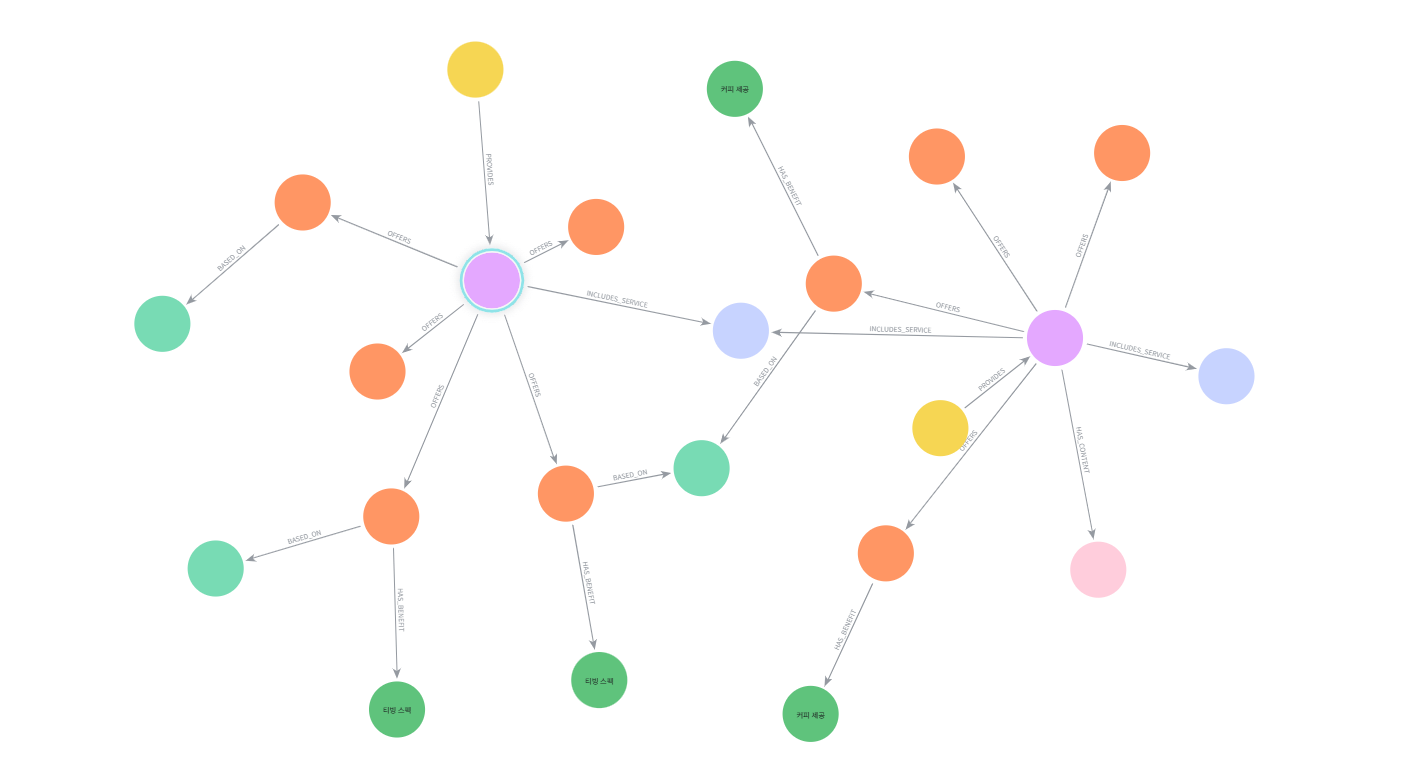

In [15]:
from IPython.display import Image
Image("bloom-visualisation.png") 

-> graph rag 생성

## retriever
1. **[Vector]** Content 노드 기반 벡터 검색 - 내용 유사도 기반 검색
   1. 컨텐츠 노드에 들어있는 chunck들의 임베딩을 기반으로 벡터 검색
2. **[VectorCypher]** 벡터 검색 + 카테고리 기반 관련 기사 - 복합 검색
   1. 벡터기반 + 그래프 기반 검색
   2. 벡터기반으로 검색을 수행하고 그거와 관련된 다른 그래프 추출
   3. retrevial 쿼리 필요
3. **[Text2Cypher]** 자연어를 Cypher로 변환한 구조적 검색
   1. llm이 cypher 쿼리문을 생성하게 만들어야함
   2. llm한에테 어떤 그래프 정보를 가지고 있는지 스키마 정보를 같이 넘겨줘야함

In [5]:
import os
from neo4j import GraphDatabase
from sentence_transformers import SentenceTransformer

In [7]:
NEO4J_DB = os.getenv("NEO4J_DB", "neo4j")  # DB 이름

In [6]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
EMBED_DIM = embed_model.get_sentence_embedding_dimension()
EMBED_DIM

384

In [8]:
#임베딩 없는 content 가져오기
def fetch_contents_without_embedding(tx, limit=200):
    q = """
    MATCH (c:Content)
    WHERE c.text IS NOT NULL AND c.text <> "" AND c.embedding IS NULL
    RETURN c.content_id AS content_id, c.text AS text
    LIMIT $limit
    """
    return list(tx.run(q, limit=limit))

#content.embedding에 임베딩 저장
def update_content_embeddings(tx, rows):
    """
    rows: [{"content_id": "...", "embedding": [float, ...]}, ...]
    """
    q = """
    UNWIND $rows AS row
    MATCH (c:Content {content_id: row.content_id})
    SET c.embedding = row.embedding,
        c.embedding_model = $model_name,
        c.embedding_dim = $dim
    """
    tx.run(q, rows=rows, model_name="sentence-transformers/all-MiniLM-L6-v2", dim=EMBED_DIM)


In [17]:
def embed_all_contents(batch_size=200, max_batches=10):
    """
    Content 중 embedding 없는 것들을 batch로 읽어서 embedding 생성 후 저장
    max_batches 늘리면 더 많이 처리
    """
    total = 0
    with driver.session(database=NEO4J_DB) as session:
        for _ in range(max_batches):
            records = session.execute_read(fetch_contents_without_embedding, batch_size)
            if not records:
                break

            texts = [r["text"] for r in records]
            ids = [r["content_id"] for r in records]

            vectors = embed_model.encode(
                texts,
                normalize_embeddings=True,   # cosine이면 normalize 추천
                convert_to_numpy=True
            )

            rows = [{"content_id": cid, "embedding": vec.tolist()} for cid, vec in zip(ids, vectors)]
            session.execute_write(update_content_embeddings, rows)

            total += len(rows)
            print(f"[OK] embedded & saved: {len(rows)} (total={total})")

    return total

embed_all_contents(batch_size=200, max_batches=100)


0

In [16]:
from neo4j_graphrag.indexes import create_vector_index

VECTOR_INDEX_NAME = "content_embedding_idx"

def ensure_vector_index():
    create_vector_index(
        driver,
        VECTOR_INDEX_NAME,   # index name
        "Content",           # label
        "embedding",         # property
        EMBED_DIM,           # dimensions
        "cosine",            # similarity function
        NEO4J_DB             # database
    )

ensure_vector_index()
print("[OK] Vector index ensured")


[OK] Vector index ensured


In [18]:
def vector_search_contents(query_text: str, top_k=5, product_id: str | None = None):
    #자연어 질문을 임베딩 벡터로 변환 
    # 벡터 검색의 기준점
    qvec = embed_model.encode([query_text], normalize_embeddings=True, convert_to_numpy=True)[0].tolist()

    # product_id로 필터링하고 싶으면 (Product)-[:HAS_CONTENT]->(Content) 경로로 제한
    # product_id=None → 전체 Content 대상 검색
    # product_id="KT_1665" → 해당 상품의 정책/콘텐츠만 검색
    cypher = """
    //query_vec : 방금 변환한 질문 임베딩 
    CALL db.index.vector.queryNodes($index_name, $top_k, $query_vec)
    YIELD node, score
    RETURN node.content_id AS content_id,
           node.text AS text,
           node.idx AS idx,
           score
    ORDER BY score DESC
    """

    cypher_with_filter = """
    CALL db.index.vector.queryNodes($index_name, $top_k, $query_vec)
    YIELD node, score
    WITH node, score
    //관계로 필터링 
    MATCH (p:Product {product_id:$pid})-[:HAS_CONTENT]->(node)
    RETURN node.content_id AS content_id,
           node.text AS text,
           node.idx AS idx,
           score
    ORDER BY score DESC
    """

    with driver.session(database=NEO4J_DB) as session:
        if product_id:
            result = session.run(
                cypher_with_filter,
                index_name=VECTOR_INDEX_NAME,
                top_k=top_k,
                query_vec=qvec,
                pid=product_id
            )
        else:
            result = session.run(
                cypher,
                index_name=VECTOR_INDEX_NAME,
                top_k=top_k,
                query_vec=qvec
            )

        return [r.data() for r in result]


In [19]:
vector_search_contents("KT 티빙 번들에서 이용 가능한 기기 제한이 뭐야? 광고형 스탠다드는 뭐가 안 돼?", top_k=5)

[{'content_id': 'KT_1665#POLICY#7',
  'text': "원하시는 경우는 '티빙 > 고객센터 > 1:1 문의' 또는 'tving@cj.net'으로 환불 신청해 주시기 바랍니다.. 기존 유료 티빙 이용권을 인앱결제(구글 및 애플)로 이용 중인 경우는 인앱 결제 사업자의 고객센터를 통해 조치(해지, 환불신청 등) 하셔야 합니다.",
  'idx': 7,
  'score': 0.7437815070152283},
 {'content_id': 'KT_1665#POLICY#2',
  'text': '발송되는 계정등록 안내문자 URL 또는 마이케이티(마이>요금/서비스>부가서비스 조회/변경>티빙계정등록하기)를 통해서만 티빙ID 계정 등록을 진행하셔야 티빙 서비스 이용이 가능합니다.. 메가MGC커피 기프티쇼는 부가서비스 가입 즉시 문자 메시지로 발송되며, 매월 부가서비스 가입 일자에 발송됩니다. 아메리카노(HOT) 상품이 제공되며, 제공된 기프티쇼는 유효기간 내 이용 가능합니다. (유효기간 30일). 아메리카노(HOT) 상품이 제공되며, 제공된 기프티쇼는 유효기간 내 이용 가능합니다. (유효기간 30일). 부가서비스 결제/취소/환불 관련해서는 아래의 정책이 적용됩니다. 1) 부가서비스 가입 후, 매월 서비스 이용료 결제일(서비스 이용기간 시작일) 기준 7일 이내 해지하시는 경우에는, 티빙 콘텐츠와 메가MGC커피 기프티쇼 이용 여부에 따라 해지 처리됩니다. 가입 후 7일 이내 티빙 콘텐츠 및 메가MGC커피 기프티쇼 사용 이력이 없는 경우, 즉시 해지가 가능하며, 명세서에  청구되지 않',
  'idx': 2,
  'score': 0.7422326803207397},
 {'content_id': 'KT_1665#POLICY#1',
  'text': '구되며, 프로모션 기간(‘25년 9월 26일 ~ ’25년 12월 31일)내 가입고객은 ‘26년 6월 30일까지 프로모션가로 이용 후 ‘26년 7월부터 KT 구독가로 이용 가능합니다.. TV 부가서비스 페이지

In [20]:
vector_search_contents("KT 번들 가입 가능한 고객 조건(선불/알뜰폰/14세 미만 등) 알려줘", top_k=5)

[{'content_id': 'KT_1665#POLICY#1',
  'text': '구되며, 프로모션 기간(‘25년 9월 26일 ~ ’25년 12월 31일)내 가입고객은 ‘26년 6월 30일까지 프로모션가로 이용 후 ‘26년 7월부터 KT 구독가로 이용 가능합니다.. TV 부가서비스 페이지에서 상품 가입 시 할인 혜택을 받을 수 없습니다.. 티빙 포함 요금제/부가서비스에 가입된 경우 중복 가입이 불가합니다.. 부가서비스를 가입한 모바일 회선이 일시중지/정지 상태이면, 가입한 부가서비스는 해지 예약 상태로 자동 변경되며 다음 결제일 도래전까지 서비스 이용 가능합니다. 다음 결제일 전에 일시중지/정지가 해제될 경우 가입한 부가서비스는 해지되지 않고 계속해서 이용 가능합니다.. 부가서비스를 가입한 모바일 회선이 해지될 경우 가입한 부가서비스는 자동 해지됩니다.. 제휴사의 사정에 의해 서비스 내용이나 상시 할인 혜택은 변경, 또는 종료될 수 있습니다.. 부가서비스 가입 후, 고객님께 발송되는 계정등록 안내문자 URL 또는 마이케이티(마이>요금/서비스>부가서비스 조회/변경>',
  'idx': 1,
  'score': 0.7066448926925659},
 {'content_id': 'KT_1665#POLICY#0',
  'text': '티빙의 차별화된 오리지널 콘텐츠 tvN, JTBC, Mnet 등 실시간 채널과 최신 인기프로그램. 메가MGC커피 아메리카노(HOT) 매월 최대 3잔 제공. 이용기기 : 스마트폰, 태블릿, 스마트TV(삼성/LG), 안드로이드 TV, 애플 TV, 지니TV 모빌리티 디바이스, 크롬캐스트/미러링(광고형 스탠다드 불가). 티빙 광고형 스탠다드는 60분 콘텐츠 1편 시청 시 최대 4분 광고가 편성됩니다.. 프로모션 기간(‘25.9.26~’25.12.31) 내 가입 고객은 ‘26년 6월 30일까지 프로모션가로 제공됩니다.. 5G/LTE 요금제 이용 중인 KT고객에게만 할인 혜택이 제공되는 KT 구독 서비스이며, 개인 명의 고객만 가입 가능합니다. 

In [29]:
driver.close()